  
  # 昆明市区火锅店最佳选址
 

## 目录  
1. [项目简介](#项目简介)
2. [区域划分及区域数据获取](#区域划分及区域数据获取)  
    2.1 [构造区域划分网格](#构造区域划分网格)  
    2.2 [区域数据获取](#区域数据获取)
3. [区域客流量、同业竞争分析](#区域客流量、同业竞争分析)  
    3.1 [利用百度地图API探索餐饮分布情况](#利用百度地图API探索餐饮分布情况)  
    3.2 [创建分布热图查看分布情况](#创建分布热图查看分布情况)  
    3.2.1[创建餐馆分布热图](#创建餐馆分布热图)  
    3.2.2[创建火锅店热图](#创建火锅店热图)  
    3.3 [二次构造区域划分网格](#二次构造区域划分网格)  
    3.4 [确定客流量，同业竞争筛选条件](#确定客流量，同业竞争筛选条件)  
    3.5 [根据条件筛选合适区域](#根据条件筛选合适区域)  
    3.5.1 [利用DBSCAN区域聚类](#利用DBSCAN区域聚类)  
4. [交通便利度分析](#交通便利度分析)  
    4.1 [使用百度地图API获取公交交通即停车场数据](#使用百度地图API获取公交交通即停车场数据)  
    4.2 [影响交通便利程度各因素综合分析](#影响交通便利程度各因素综合分析)  
    4.3 [交通便利程度分析结果](#交通便利程度分析结果)
5. [区域租金探索](#区域租金探索)  
    5.1 [构建爬虫从58同城抓取昆明待租商铺信息](#构建爬虫)  
    5.2 [数据清洗](#数据清洗)  
    5.3 [获取商铺经纬度坐标](#获取商铺经纬度坐标)  
    5.4 [获取候选区域内的商铺租金信息](#获取候选区域内的商铺租金信息)  
6. [总结分析](#总结分析)  
    6.1 [使用气泡图确定最终结果](#使用气泡图确定最终结果)    
7. [结论](#结论)    


## 1.项目简介<a name="项目简介"></a>

本项目旨在通过对昆明餐饮业数据搜集和分析，探寻火锅店的最佳选址。

昆明作为云南的省会城市，同时也是一个有名的旅游城市，餐饮行业竞争尤为激烈。想要在昆明开一家火锅店，前期选址就显得尤为重要：要在保证能够获得足够多的客源的同时尽量降低成本。为此，我将从：**客流量**，**同业竞争程度**，**交通便利程度**，**租金投入**四个角度对火锅店的区域位置优劣程度进行评判，试图探寻最佳的选址。

在餐厅选址过程中，客流量当然是最重要的。其次则是周边同业竞争程度，这将之间影响客流量。再次则是交通便利程度，交通越是便利，餐厅辐射面积将大大增加，潜在客户也就越多。当然，餐厅投入成本也是很重要的，其中和区域位置关系最大的就是店铺租金。为了不让租金限制我们的选择，我将把租金部分留到最后。

## 2.区域划分及区域数据获取<a name="区域划分及区域数据获取"></a>

为了尽可能的覆盖中部核心区域，首先将以五华区政府为中心，半径6公里范围内划定为待分析区域。  

In [3]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

#定义坐标获取函数
def get_coordinates(address, verbose=False,recursion=0):
    try:
        geolocator = Nominatim(user_agent = 'km_explore')
        location = geolocator.geocode(address, timeout=10)
        if verbose:
            print('Geopy result =>',location)
        lat = location.latitude
        lon = location.longitude
        return [lat, lon]
    except GeocoderTimedOut as e:
        if recursion< 10:
            time.sleep(1)  #避免Timeout
            return get_coordinates(address,recursion=recursion+1)   
        else:
            print('Error:',e)
            return [None, None]


In [4]:
#获取圆心及五华区政府位置坐标
address='五华区政府, 五华区, 昆明市, 云南省, China 中国'
KM_wh = get_coordinates(address)
print('Coordinate of {}: {}'.format(address, KM_wh))

Coordinate of 五华区政府, 五华区, 昆明市, 云南省, China 中国: [25.0465871, 102.70540813035652]


In [5]:
# !pip install pyproj   #制图投影和坐标转换库
#!pip install shapely  #操纵和分析平面几何对象

In [6]:
import shapely
import pyproj
import math

#坐标转换，便于进行坐标位置运算
def lonlat_to_xy(lon, lat):
#     zone = int(lon/6)+31    #UTM投影分带
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84') #坐标转换为原始地图投影 X，Y
    proj_xy = pyproj.Proj(proj="utm", zone=48, datum='WGS84')  
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
#     zone = int(lon/6)+31
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')  
    proj_xy = pyproj.Proj(proj="utm", zone=48, datum='WGS84')  
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

#位置距离计算
def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('五华区政府 longitude={}, latitude={}'.format(KM_wh[1], KM_wh[0]))
x, y = lonlat_to_xy(KM_wh[1], KM_wh[0])
print('五华区政府 UTM X={}, Y={}'.format(x , y))
lo, la = xy_to_lonlat(x, y)
print('五华区政府 longitude={}, latitude={}'.format(lo,la))

Coordinate transformation check
-------------------------------
五华区政府 longitude=102.70540813035652, latitude=25.0465871
五华区政府 UTM X=268500.80656844034, Y=2772069.476595298
五华区政府 longitude=102.70540813035652, latitude=25.046587100000004


### 2.1 构建区域划分网格<a name="构建区域划分网格"></a>
为了便于具体分析，将整个区域划分为一个由圆形单元格组成的近似六边形网格。每个单元格半径为500米，且每个单元格间中心距相等。

In [7]:
KM_wh_x, KM_wh_y = lonlat_to_xy(KM_wh[1], KM_wh[0])

k = math.sqrt(3) / 2    #单元格垂直偏移量
x_min = KM_wh_x - 6000
x_step = 1000
y_min = KM_wh_y - 6000 - (int(21/k)*k*1000 - 12000)/2
y_step = 1000 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []

for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 500 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(KM_wh_x, KM_wh_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)
            
print('区域划分完成，共生成{}个候选区域'.format(len(latitudes)))

区域划分完成，共生成130个候选区域


将候选区域标记在地图上

In [8]:
import folium

map_wh = folium.Map(location=KM_wh, zoom_start=13)
folium.Marker(KM_wh, popup='wuhua').add_to(map_wh)
for lat, lon in zip(latitudes,longitudes):
    folium.Circle([lat, lon], radius=500, color='blue', fill=False).add_to(map_wh)

map_wh

从地图上看，候选区域横跨了西山区，五华区，官渡区，盘龙区，完美的覆盖了市中心。但同时也覆盖了部分人烟稀少的区域，有些区域甚至位于滇池上。因此，后面需要根据餐厅分布情况对整个候选区域与进行进一步调整。

### 2.2 区域数据获取<a name="区域数据获取"></a>

In [9]:
#使用Geopy根据经纬度获取区域地理位置信息
def get_address(latitude, longitude, verbose = False):
    try:
        geolocator = Nominatim(user_agent='CG_explorer')
        location = geolocator.reverse([latitude,longitude], timeout=100)
        if verbose:
            print('Geopy API result =>',location)
        data = location.raw
        data = data['address']
 #       print(data)
        try:
            road = data['road']
        except:
            road =''
        try:
            hamlet = data['hamlet']
        except:
            hamlet = ''
        try:
            town = data['town']
        except:
            town = data['county']
        try:
            townhall = data['townhall']
        except:
            townhall = ''
        
        address = town + ' '+ hamlet + ' ' + road +' ' + townhall
        return address
    except Exception as e:
        raise

In [10]:
addr = get_address(KM_wh[0], KM_wh[1])

print('Reverse geocoding check')
print('Address of [{}, {}] is:{}'.format(KM_wh[0], KM_wh[1], addr))

Reverse geocoding check
Address of [25.0465871, 102.70540813035652] is:护国街道  人民中路 


In [11]:
import pickle

try:
    with open('addresses.pkl','rb') as f:
        addresses = pickle.load(f)
        print('从本地获取区域位置成功')
except:
    print('通过Geopy获取划分区域位置：',end='')
    addresses = []
    for lat, lon in zip(latitudes, longitudes):
        address = get_address(lat, lon)
        if address is None:
            address = 'NO ADDRESS'
        addresses.append(address)
        print('.', end='')
    print('获取区域位置成功!')
    with open('addresses.pkl','wb') as f:
        pickle.dump(address,f)
        print('区域位置信息已保存到本地')

从本地获取区域位置成功


In [12]:
len(addresses)

130

In [13]:
#将获取的信息保存为DataFrame
import pandas as pd

df_location = pd.DataFrame({'Address': addresses,
                           'Latitude': latitudes,
                           'Longitude': longitudes,
                           'X': xs,
                           'Y': ys,
                           'Distance from center': distances_from_center})

df_location.head(10)

,Address,Latitude,Longitude,X,Y,Distance from center
0,福海街道,24.999314,102.681526,266000.806568,2.766873e+06,5766.281297
1,福海街道 日新路,24.999468,102.691427,267000.806568,2.766873e+06,5408.326913
2,前卫街道 日新路,24.999622,102.701329,268000.806568,2.766873e+06,5220.153254
3,前卫街道,24.999774,102.711231,269000.806568,2.766873e+06,5220.153254
4,关上街道,24.999926,102.721133,270000.806568,2.766873e+06,5408.326913
5,关上街道,25.000078,102.731035,271000.806568,2.766873e+06,5766.281297
6,福海街道,25.006896,102.666526,264500.806568,2.767739e+06,5894.913061
7,福海街道,25.007052,102.676428,265500.806568,2.767739e+06,5267.826876
8,福海街道,25.007206,102.686330,266500.806568,2.767739e+06,4769.696007
9,前卫街道,25.007360,102.696233,267500.806568,2.767739e+06,4444.097209


In [14]:
# 数据保存到本地便于使用
df_location.to_pickle('./locations.pkl')

## 3.区域客流量、同业竞争分析<a name="区域客流量、同业竞争分析"></a>

**客流量**即客户流动的数量，很难直接获得该数据。我们转变思路：餐饮业特别看重客流量，客流量大的区域避让有较多的餐饮业入驻。同时，餐饮业聚集区域也会吸引更多的客户聚集，所有只要获得整个区域内餐饮业分布情况，餐饮业聚集的区域即我们想要的客流量较高的区域。  

但并非餐厅越多的地方就越好，餐厅越多，**同业竞争程度**就越是激烈，所以，需要选取适中的的值。

### 3.1 利用百度地图API探索餐饮分布情况<a name="利用百度地图API探索餐饮分布情况"></a>

In [15]:
import requests
import math
import time
import pickle

In [16]:
def is_restaurant(name, tag, specific_filter=None):
    restaurant_tags=['中餐厅','外国餐厅']
    restaurant = False
    specific = False
    if tag in restaurant_tags:
        restaurant = True
    if not(specific_filter is None) and (specific_filter in name):
        specific = True
        restaurants = True
    return restaurant, specific

def format_address(address):
    temp_address = ['云南省','昆明市']
    for addr in temp_address:
        if addr in address:
            address = address.replace(addr,'')
    return address

def format_tag(tag):
#     temp_tag = '美食;'
    tag = tag.replace('美食;','')
    return tag

In [17]:
def get_venues_near_location(lat, lon, radius, query, tag, page_num,ak):
    url = 'http://api.map.baidu.com/place/v2/search?query={}&tag={}&location={},{}&radius={}&page_size=20&page_num={}&scope=2&output=json&ak={}'.format(query,tag,lat,lon,radius,page_num,ak)
    temp = requests.get(url).json()
    results = []
    venues = []
    if temp['status'] == 0:
        results = results + temp['results']
        total = temp['total']
        #每个位置仅选取产所不超过400个
        if total <= 400:
            pages = math.ceil(total/20)
        else:
            pages = 20
 #       print('正在查询，预计用时:{}秒'.format(total/100))
        for i in range(1, pages):
            uri = 'http://api.map.baidu.com/place/v2/search?query={}&tag={}&location={},{}&radius={}&page_size=20&page_num={}&scope=2&output=json&ak={}'.format(query,tag,lat,lon,radius,i,ak)
            temp_i = requests.get(uri).json()
            result = temp_i['results']
            results = results + result
            time.sleep(0.1)   #防止并发超峰值
            
        for item in results:
            try:
                venues.append((item['uid'],item['name'],format_tag(item['detail_info']['tag']),
                            (item['location']['lat'],item['location']['lng']),
                            format_address(item['address']),item['detail_info']['distance']))
            except Exception as e:
                print('error:',e)
                print(item)

    else:
        print('查询失败，status={}'.format(temp['status'])) 
        
    return venues

In [242]:
ak = '4i9M0NtHUOduiWwjuUS9x9D0gVQ286VL'

In [19]:
query = "美食$湘菜$川菜$火锅$西餐$烤肉$云南菜$饭$菜$料理"
tag = '美食'

In [20]:
def get_restaurants(lats, lons):
    restaurants = {}
    hotpot_restaurants = {}
    location_restaurants = []
    
    print('获取附近场地:',end='')
    for lat, lon in zip(lats, lons):
        #使用radius=550，保证涵盖地图所有位置
        venues = get_venues_near_location(lat, lon, radius='550', query=query, tag=tag, page_num='0',ak=ak)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_tag = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_hotpot = is_restaurant(venue_name, venue_tag, specific_filter='火锅')
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0],venue_latlon[1],venue_address,venue_distance,is_hotpot,x,y)
                if venue_distance <= 500:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_hotpot:
                    hotpot_restaurants[venue_id] = restaurant
        location_restaurants.append(area_restaurants)  
        print('.',end='')
    print('done!')
    return restaurants, hotpot_restaurants, location_restaurants


In [21]:
#优先调用已保存数据
restaurants = {}
hotpot_restaurants = {}
location_restaurants = []
loaded = False

try:
    with open('restaurants.pkl','rb') as f:
        restaurants = pickle.load(f)
    with open('hotpot_restaurants.pkl','rb') as f:
        hotpot_restaurants = pickle.load(f)
    with open('location_restaurants.pkl','rb') as f:
        location_restaurants = pickle.load(f)
    print('成功从本地加载餐厅数据')
    loaded = True
except:
    pass

#本地无数据时调用百度API获取数据
if not loaded:
    restaurants, hotpot_restaurants, location_restaurants = get_restaurants(latitudes,longitudes)
    
    #将数据保存到本地便于调用
    with open('restaurants.pkl','wb') as f:
        pickle.dump(restaurants, f)
    with open('hotpot_restaurants.pkl','wb') as f:
        pickle.dump(hotpot_restaurants, f)
    with open("location_restaurants.pkl",'wb') as f:
        pickle.dump(location_restaurants, f)
    print('成功调用百度API获取餐厅数据，数据已保存到本地')

成功从本地加载餐厅数据


In [22]:
import numpy as np

print('餐馆总数:',len(restaurants))
print('火锅店总数:',len(hotpot_restaurants))
print('火锅店比例:{:.2f}%'.format(len(hotpot_restaurants)/len(restaurants) * 100))
print('区域内平均餐馆数量:', np.array([len(r) for r in location_restaurants]).mean())
      

餐馆总数: 3384
火锅店总数: 406
火锅店比例:12.00%
区域内平均餐馆数量: 32.80769230769231


通过百度地图API我们抓取个整个区域内的餐厅情况，现将其标记在地图上。火锅店为红色，其他餐馆为蓝色。

In [23]:
map_wh = folium.Map(location=KM_wh, zoom_start=10)
#folium.Marker(KM_wh, popup='wuhua').add_to(map_wh)

for res in restaurants.values():
    lat = res[2]
    lon = res[3]
    is_hotpot = res[6]
    if is_hotpot:
        color = 'red'
    else:
        color = 'blue'
    folium.CircleMarker([lat, lon], radius=2, color=color, fill=True,fill_color=color, fill_opacity=1).add_to(map_wh)



In [27]:
#数据太多jupyterlab无法显示，储存为html用浏览器打开
import webbrowser

try:
    webbrowser.open('Map_wh.html')
except:
    map_wh.save('Map_wh.html')
    webbrowser.open('Map_wh.html')


对获取的数据做一些简单的分析，了解分布情况

In [25]:
location_restaurants_count = [len(res) for res in location_restaurants]

df_location['Restaurants in area'] = location_restaurants_count

print('每半径500米区域内平均餐馆数量:',np.array(location_restaurants_count).mean())

df_location.head()

每半径500米区域内平均餐馆数量: 32.80769230769231


,Address,Latitude,Longitude,X,Y,Distance from center,Restaurants in area
0,福海街道,24.999314,102.681526,266000.806568,2.766873e+06,5766.281297,20
1,福海街道 日新路,24.999468,102.691427,267000.806568,2.766873e+06,5408.326913,56
2,前卫街道 日新路,24.999622,102.701329,268000.806568,2.766873e+06,5220.153254,18
3,前卫街道,24.999774,102.711231,269000.806568,2.766873e+06,5220.153254,31
4,关上街道,24.999926,102.721133,270000.806568,2.766873e+06,5408.326913,11


计算每个区域内距离中心最近的火锅店的距离

In [26]:
distance_to_hotpot= []

for area_x, area_y in zip(xs, ys):
    min_distance = 1000
    for res in hotpot_restaurants.values():
        res_x = res[7]
        res_y = res[8]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d < min_distance:
            min_distance = d
    distance_to_hotpot.append(min_distance)

df_location['Distance to hotpot restaurant'] = distance_to_hotpot

In [27]:
df_location.describe()

,Latitude,Longitude,X,Y,Distance from center,Restaurants in area,Distance to hotpot restaurant
count,130.000000,130.000000,130.000000,1.300000e+02,130.000000,130.000000,130.000000
mean,25.046584,102.705408,268500.806568,2.772069e+06,3989.997726,32.807692,373.888996
std,0.026812,0.030077,3035.960188,2.970788e+03,1413.910294,20.899945,254.932740
min,24.999314,102.650630,263000.806568,2.766873e+06,500.000000,0.000000,26.062911
25%,25.023485,102.680718,266000.806568,2.769471e+06,3041.381265,20.250000,192.760968
50%,25.046587,102.705408,268500.806568,2.772069e+06,4272.001873,32.000000,307.130320
75%,25.069685,102.730100,271000.806568,2.774668e+06,5220.153254,44.750000,439.955002
max,25.093857,102.760174,274000.806568,2.777266e+06,5894.913061,118.000000,1000.000000


从获取数据看，区域内75%区域的餐厅数量在45家以下，但25%的区域在45-118家，该数量跨度较大，不便于进行餐厅数量的筛选。导致这个问题的原因是单元格半径设置过大，造成数据差异较大，需要缩小单元格半径细化数据。  
再正式缩小单元格半径前，先通过区域分布热图看看是否能根据餐厅分布情况选定更好的候选区域。

### 3.2 创建分布热图<a name="创建分布热图"></a>

#### 3.2.1 创建餐馆分布热图<a name="创建餐馆分布热图"></a>

In [28]:
restuarant_latlons = [[res[2],res[3]] for res in restaurants.values()]
hotpot_latlons = [[res[2],res[3]] for res in hotpot_restaurants.values()]

In [28]:
#餐馆热图
from folium.plugins import HeatMap

heatmap_res = folium.Map(location=KM_wh, zoom_start=13)
#folium.TileLayer('cartodbpositron').add_to(heatmap_res)  #浅色卡通图层

#热图图层
HeatMap(restuarant_latlons).add_to(heatmap_res)
folium.Marker(KM_wh).add_to(heatmap_res)
folium.Circle(KM_wh, radius=1000, fill=False, color='white').add_to(heatmap_res)
folium.Circle(KM_wh, radius=2000, fill=False, color='white').add_to(heatmap_res)
folium.Circle(KM_wh, radius=3000, fill=False, color='white').add_to(heatmap_res)


In [ ]:
#将地图保存用浏览器打开
try:
    webbrowser.open('map_restaurants.html')
except:
    heatmap_res.save('map_restaurants.html')
    webbrowser.open('map_restaurants.html')

#### 3.2.2 创建火锅店分布热图<a name="创建火锅店分布热图"></a>

In [29]:
#火锅热图
from folium.plugins import HeatMap

heatmap_hotpot = folium.Map(location=KM_wh, zoom_start=13)
#folium.TileLayer('cartodbpositron').add_to(heatmap_hotpot)  #浅色卡通图层
HeatMap(hotpot_latlons).add_to(heatmap_hotpot)
folium.Marker(KM_wh).add_to(heatmap_hotpot)
folium.Circle(KM_wh, radius=1000, fill=False, color='white').add_to(heatmap_hotpot)
folium.Circle(KM_wh, radius=2000, fill=False, color='white').add_to(heatmap_hotpot)
folium.Circle(KM_wh, radius=3000, fill=False, color='white').add_to(heatmap_hotpot)

#heatmap_hotpot

In [32]:
try:
    webbrowser.open('map_hotpot.html')
except:
    heatmap_hotpot.save('map_hotpot.html')
    webbrowser.open('map_hotpot.html')

从热图上看，餐厅和火锅店的分布都比较分散，没有明显分布规律，且在边缘餐饮业分布较少，故：将分析半径缩减到半径4KM，网格直径由500m减小为为100m。

### 3.3 二次构造区域划分网格<a name="二次构造区域划分网格"></a>

In [30]:
#sele means selected
sele_center_x, sele_center_y = lonlat_to_xy(KM_wh[1], KM_wh[0])

sele_x_min = sele_center_x - 4000
sele_x_max = sele_center_x + 4000
sele_y_min = sele_center_y - 4000
sele_y_max = sele_center_y + 4000

sele_area_width = 8000
sele_area_height = 8000

#创建网格
k = math.sqrt(3)/2
x_step = 100
y_step = 100 * k

sele_latitudes = []
sele_longitudes = []
sele_xs = []
sele_ys = []
for i in range(0,int(81/k)):
    y = sele_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0,81):
        x = sele_x_min + j * x_step + x_offset
        d = calc_xy_distance(sele_center_x, sele_center_y, x, y)
        if (d<= 4001):
            lon, lat = xy_to_lonlat(x, y)
            sele_latitudes.append(lat)
            sele_longitudes.append(lon)
            sele_xs.append(x)
            sele_ys.append(y)

print(len(sele_latitudes),'个网格区域创建完成')

5806 个网格区域创建完成


### 3.4 确定客流量，同业竞争筛选条件<a name="确定客流量，同业竞争筛选条件"></a>

前面已经讨论过，在区域选择时，选定区域内的餐厅数量应该适中，即：**区域内既要有一定数量的餐厅聚集以确保能有足够的客流量，但又数量不能太多，避免同类竞争竞争过于激烈**。在选择千年，我们需要了解各个区域内餐饮具体分布情况。

In [31]:
def count_res_nearby(x, y, restaurants, radius=200):
    count = 0
    for res in restaurants.values():
        res_x = res[7]
        res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 8000
    for res in restaurants.values():
        res_x = res[7]
        res_y = res[8]
        d = calc_xy_distance(res_x, res_y, x, y)
        if d<=d_min:
            d_min = d
    return d_min


In [32]:
sele_restaurant_counts = []     
sele_hotpot_counts = []

print('正在检索候选区域数据...', end='')
for x, y in zip(sele_xs, sele_ys):
    count = count_res_nearby(x, y, restaurants,radius=200)
    sele_restaurant_counts.append(count)
    distance = find_nearest_restaurant(x, y, restaurants)
    sele_hotpot_counts.append(distance)
print('done!')

正在检索候选区域数据...done!


In [33]:
#将检索信息增加到dataframe中

df_sele_area = pd.DataFrame({'Latitude':sele_latitudes,
                             'Longitude':sele_longitudes,
                             'X':sele_xs,
                             'Y':sele_ys,
                             'Restaurants':sele_restaurant_counts,
                             'Distance to hotpot':sele_hotpot_counts
                            })

df_sele_area.head()

,Latitude,Longitude,X,Y,Restaurants,Distance to hotpot
0,25.010484,102.705584,268450.806568,2.768069e+06,13,50.664529
1,25.010500,102.706575,268550.806568,2.768069e+06,12,27.504827
2,25.011151,102.698143,267700.806568,2.768156e+06,8,16.557181
3,25.011166,102.699133,267800.806568,2.768156e+06,15,52.218869
4,25.011182,102.700123,267900.806568,2.768156e+06,14,87.137892


In [34]:
df_sele_area.describe()

,Latitude,Longitude,X,Y,Restaurants,Distance to hotpot
count,5806.000000,5806.000000,5806.000000,5.806000e+03,5806.000000,5806.000000
mean,25.046576,102.705408,268500.806568,2.772068e+06,4.598691,132.639259
std,0.018069,0.019802,1998.820496,2.002139e+03,4.840700,105.839656
min,25.010484,102.665774,264500.806568,2.768069e+06,0.000000,1.891157
25%,25.031975,102.689433,266900.806568,2.770429e+06,1.000000,63.510168
50%,25.046625,102.705411,268500.806568,2.772053e+06,3.000000,107.501460
75%,25.061100,102.721377,270100.806568,2.773699e+06,7.000000,168.045167
max,25.082457,102.745020,272500.806568,2.776037e+06,38.000000,903.419719


现在我们已经获取了各个区域内的餐厅分布情况，由此可以划定区域筛选条件：  
1.为了保证客流量且避免餐饮业竞争过于激烈：限定**单元区域半径100米范围内餐馆数量不少于7家，不大于12家**  
2.为了尽量避免同业竞争：限定**半径100米范围内没有火锅店**。

### 3.5 根据条件筛选合适区域<a name="根据条件筛选合适区域"></a>

In [40]:
good_res_count = np.array((df_sele_area['Restaurants']<=12) & (df_sele_area['Restaurants']>=7))
print('备选区域中餐馆数量为7-12家的区域共有{}处'.format(good_res_count.sum()))

good_hotpot_distance = np.array(df_sele_area['Distance to hotpot']>=100)
print('备选区域中100范围内没有火锅店的区域共有{}处'.format(good_hotpot_distance.sum()))

good_locations = np.logical_and(good_res_count, good_hotpot_distance)
print('满足条件的区域共有{}处'.format(good_locations.sum()))

df_good_locations = df_sele_area[good_locations]

备选区域中餐馆数量为7-10家的区域共有1070处
备选区域中100范围内没有火锅店的区域共有3130处
满足条件的区域共有223处


将符合要求的区域标记在地图上

In [41]:
good_latitudes = df_good_locations['Latitude']
good_longitudes = df_good_locations['Longitude']

map_good = folium.Map(location=KM_wh, zoom_start=14)

#HeatMap(restuarant_latlons).add_to(map_good)

folium.Circle(KM_wh, radius=1000, color='white').add_to(map_good)
folium.Circle(KM_wh, radius=2000, color='white').add_to(map_good)
folium.Circle(KM_wh, radius=3000, color='white').add_to(map_good)
folium.Circle(KM_wh, radius=4000, color='white').add_to(map_good)

for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue',fill_opacity=1).add_to(map_good)

map_good.save('map_good.html')
    

In [ ]:
webbrowser.open('map_good.html')

#### 3.5.1 利用DBSCAN区域聚类<a name="利用DBSCAN区域聚类"></a>

区域聚类的目的是使我们能够更有针对性的进行分析和实际探索。我们使用DBSCAN进行聚类，挑选出合适的区域。

In [42]:
df_good_locations = df_good_locations.reset_index(drop=True)

In [51]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

sklearn.utils.check_random_state(1000)
clus_dataset = df_good_locations[['X','Y']]
clus_dataset = StandardScaler().fit_transform(clus_dataset)

#DBSCAN
db = DBSCAN(eps=0.175,min_samples=4).fit(clus_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_good_locations['Clus_Db']=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

In [52]:
df_good_locations['Clus_Db'].value_counts()

-1     111
 14     10
 1       9
 18      8
 5       7
 11      7
 3       6
 16      6
 6       6
 8       5
 0       5
 13      5
 19      5
 4       5
 2       4
 17      4
 7       4
 9       4
 12      4
 15      4
 10      4
Name: Clus_Db, dtype: int64

通过DBSCAN，一共得到了11组聚类结果,每个结果都是一个数据集合，接下来我们将其标记在地图上。

In [53]:
tites='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png'   #cartodbpositron
attr = '<a href="http://cartodb.com/attributions">CartoDB</a>'

clust_map = folium.Map(location=KM_wh, tiles=tites, attr=attr, zoom_start=14)
folium.Circle(KM_wh, radius=1000, color='lightblue').add_to(clust_map)
folium.Circle(KM_wh, radius=2000, color='lightblue').add_to(clust_map)
folium.Circle(KM_wh, radius=3000, color='lightblue').add_to(clust_map)
folium.Circle(KM_wh, radius=4000, color='lightblue').add_to(clust_map)

# colors = ['red','blue', 'green', 'purple', 'orange', 'darkred','black', 'beige', 'darkblue', 'darkgreen', 
#           'cadetblue', 'lightgreen', 'gray', 'pink', 'lightblue']

# colors = np.random.rand(len(set(labels)))  # 颜色数组

colors = ['lightgreen', 'red', 'black', 'purple', 'lightblue', 'orange', 'pink', 'gray', 'lightgray','darkred',
          'darkgreen', 'darkblue', 'blue', 'red', 'green', 'lightred', 'beige', 'cadetblue', 'darkpurple','lightgreen', 'beige']

clust_labels = []
clust_centers = []
center_lats = []
center_lons = []
center_x = []
center_y = []
cover_radius = []

#visualization
for clust_number in set(labels):
    if clust_number == -1:
        c = [0.4,0.4,0.4]
        clust_set = df_good_locations[df_good_locations.Clus_Db==clust_number]
        #离群值标记为点
        for lat,lon in zip(clust_set['Latitude'],clust_set['Longitude']):
            folium.CircleMarker([lat, lon], radius=2, color=c, fill=True, fill_color=c,fill_opacity=1).add_to(clust_map)    
    else:
        clust_labels.append(clust_number)
        
        c = colors[np.int(clust_number)]
        #有效值标记其覆盖范围
        clust_set = df_good_locations[df_good_locations.Clus_Db==clust_number]
        for lat,lon in zip(clust_set['Latitude'],clust_set['Longitude']):
            folium.Circle([lat, lon], radius=50, color=c, fill=True, fill_color=c,fill_opacity=0.3).add_to(clust_map)
    
    if clust_number != -1:
        cenx=np.mean(clust_set.X)
        ceny=np.mean(clust_set.Y)
        cen_lon, cen_lat = xy_to_lonlat(cenx,ceny)
        cen_addr = get_address(cen_lat,cen_lon)
        popup = '第{}组:位于{},坐标为{}'.format(str(clust_number),cen_addr,[cen_lon,cen_lat])
        folium.Marker([cen_lat, cen_lon],popup=popup,icon=folium.Icon(color=colors[np.int(clust_number)])).add_to(clust_map)
          
        clust_centers.append(cen_addr)
        center_lats.append(cen_lat)
        center_lons.append(cen_lon)
        center_x.append(cenx)
        center_y.append(ceny)
    
    #计算集群中心辐射半径
    if clust_number != -1:
        distance_temp = []
        for clus_x,clus_y in zip(clust_set.X, clust_set.Y):
            clus_cent_dis = calc_xy_distance(clus_x,clus_y,cenx,ceny)
            distance_temp.append(clus_cent_dis)

        cover_radius.append(max(distance_temp))  
        
clust_map.save('clust_map.html')

In [58]:
#去掉离群值
df_good_locations = df_good_locations[df_good_locations['Clus_Db'] != -1]
df_good_locations.reset_index(drop=True)

,Latitude,Longitude,X,Y,Restaurants,Distance to hotpot,Clus_Db
0,25.012974,102.714949,269400.806568,2.768329e+06,7,121.468451,0
1,25.013732,102.713449,269250.806568,2.768416e+06,10,134.027049,0
2,25.015280,102.712429,269150.806568,2.768589e+06,9,127.237903,0
3,25.016069,102.712910,269200.806568,2.768676e+06,11,110.189338,0
4,25.016858,102.713391,269250.806568,2.768762e+06,7,139.835975,0
...,...,...,...,...,...,...,...
107,25.069454,102.727776,270800.806568,2.774565e+06,10,107.042957,19
108,25.069530,102.732730,271300.806568,2.774565e+06,7,135.734108,18
109,25.070986,102.725765,270600.806568,2.774738e+06,11,131.857056,19
110,25.071017,102.727747,270800.806568,2.774738e+06,8,126.387699,19


In [ ]:
webbrowser.open('clust_map.html')

最后，我们将候选区域中心位置以表格形式呈现出来，便于我们继续分析。

In [63]:
results = pd.DataFrame({'label':clust_labels,
                        'address':clust_centers,
                        'latitude':center_lats,
                        'longitude':center_lons,
                        'X':center_x,
                        'Y':center_y,
                        'Cover radius':cover_radius
                       })
results.set_index('label',inplace = True)

In [64]:
results

,address,latitude,longitude,X,Y,Cover radius
label,,,,,,
0,前卫街道,25.014983,102.713426,269250.806568,2.768554e+06,270.554985
1,金碧街道,25.024259,102.692064,267111.917680,2.769619e+06,490.401700
2,金碧街道 滇池路,25.024626,102.697520,267663.306568,2.769650e+06,195.256242
3,太和街道,25.029438,102.718111,269750.806568,2.770148e+06,264.575131
4,大观街道 西昌路,25.032871,102.697440,267670.806568,2.770564e+06,330.454233
5,吴井街道 朝阳路,25.039074,102.734776,271450.806568,2.771187e+06,400.000000
6,大观街道 新闻路,25.039885,102.694387,267375.806568,2.771346e+06,202.072594
7,棕树营街道,25.043877,102.678830,265813.306568,2.771815e+06,313.249102
8,西苑街道,25.045608,102.672035,265130.806568,2.772019e+06,177.763888


至此，已经初步选定了20个候选区域。接下来对这些区域的交通便利程度进行探索。

## 4. 交通便利度分析<a name="交通便利度分析"></a>

交通便利程度主要包括公交交通及自驾两个方面：   
* .公共交通  
公交交通，在这里主要指公交车及地铁。可以通过探索候选区域附近公交线路即地铁覆盖情况确定。
* .自驾  
在此项目中，我们认为影响自驾便利程度的主要因素为是否有停车场。因此，通过探索周边停车场数量即可确定自驾便利程度。  

以上数据都可以通过百度地图API获取

### 4.1 使用百度地图API获取公交交通及停车场数据<a name="使用百度地图API获取公交交通及停车场数据"></a>

In [56]:
#定义公共交通获取函数, 该函数获取区域范围内有效的公交线路和地铁线路
def get_PT_near_location(lat, lon, ak,radius=1000 ,page_num=0):
    bus = []
    subway = []
    results = []
    query = "公交车站$地铁站"
    tag = "公交车站,地铁站"
    url = 'http://api.map.baidu.com/place/v2/search?query={}&tag={}&location={},{}&radius={}&page_size=20&page_num={}&scope=2&output=json&ak={}'.format(query,tag,lat,lon,radius,page_num,ak)
    temp = requests.get(url).json()
    if temp['status'] == 0:
        results = results + temp['results']
        pages = math.ceil(temp['total']/20)
        
        for page in range(1, pages):
            uri = 'http://api.map.baidu.com/place/v2/search?query={}&tag={}&location={},{}&radius={}&page_size=20&page_num={}&scope=2&output=json&ak={}'.format(query,tag,lat,lon,radius,page,ak)
            temp_i = requests.get(uri).json()
            result = temp_i['results']
            results = results + result
            time.sleep(0.1)   #防止并发超峰值
        
        for item in results:
            try:
                if item['detail_info']['tag'] == '公交车站':
                    if item['detail_info']['distance'] <= 500: #公交有效范围定为500米
                        bus = bus + item['address'].split(';')

                elif item['detail_info']['tag'] == '地铁站' :
                    if item['detail_info']['distance'] <= 1000 :  #地铁有效范围定位1000米
                        subway = subway + item['address'].split(';')
                        
            except:
                continue
                
        #判断是否为空，消除重复值
        if bus:
            bus = list(set(bus))
        if subway:
            subway = list(set(subway))
        
    else:
        print('查询失败，status={}'.format(temp['status'])) 
        
    return bus, subway
                

In [57]:
#停车场获取函数
def get_park_near_location(lat, lon, ak,radius=500 ,page_num=0):
    park = []
    results = []
    query = "停车场"
    tag = "停车场"
    url = 'http://api.map.baidu.com/place/v2/search?query={}&tag={}&location={},{}&radius={}&page_size=20&page_num={}&scope=2&output=json&ak={}'.format(query,tag,lat,lon,radius,page_num,ak)
    temp = requests.get(url).json()
    if temp['status'] == 0:
        results = results + temp['results']
        pages = math.ceil(temp['total']/20)
        
        for page in range(1, pages):
            uri = 'http://api.map.baidu.com/place/v2/search?query={}&tag={}&location={},{}&radius={}&page_size=20&page_num={}&scope=2&output=json&ak={}'.format(query,tag,lat,lon,radius,page,ak)
            temp_i = requests.get(uri).json()
            result = temp_i['results']
            results = results + result
            time.sleep(0.1)   #防止并发超峰值
            
        for item in results:
            try:
                if item['detail_info']['tag'] == '交通设施;停车场':
                    if item['detail_info']['distance'] <= radius: #停车场有效范围500米
                        park.append(item['uid'])   #停车场使用uid区分
                        
            except Exception as e:
                print('error:',e)
                print(item)
                
    else:
        print('查询失败，status={}'.format(temp['status'])) 
        
    return park
                
        

调用百度地图API探索每个候选区域

In [66]:
#优先调用本地数据
try:
    results = pd.read_pickle('./results.pkl')
    print('从本地调用DataFrame:results')
except:
    Bus_nums = []; Subway_nums = []; Park_nums = []
    for i in range(0,20):
        Bus = []; Subway = []; Park = []
        for index,row in df_good_locations.iterrows():
            if row['Clus_Db'] == i:
                bus, subway = get_PT_near_location(row['Latitude'], row['Longitude'], ak)
                Bus = Bus + bus
                Subway = Subway + subway

                park = get_park_near_location(row['Latitude'], row['Longitude'], ak)
                Park = Park + park
        Bus_nums.append(len(set(Bus)))
        Subway_nums.append(len(set(Subway)))
        Park_nums.append(len(set(park)))

    # 将搜索数据增加到results
    results['Bus_Nums'] = Bus_nums
    results['Subway_Nums'] = Subway_nums
    results['Park_Nums'] = Park_nums

    #保存到本地便于下次调用
    results.to_pickle('./results.pkl')
    
    print('数据抓取成功并保存到本地！')

数据抓取成功并保存到本地！


In [67]:
results

,address,latitude,longitude,X,Y,Cover radius,Bus_Nums,Subway_Nums,Park_Nums
label,,,,,,,,,
0,前卫街道,25.014983,102.713426,269250.806568,2.768554e+06,270.554985,16,0,23
1,金碧街道,25.024259,102.692064,267111.917680,2.769619e+06,490.401700,21,0,10
2,金碧街道 滇池路,25.024626,102.697520,267663.306568,2.769650e+06,195.256242,16,0,16
3,太和街道,25.029438,102.718111,269750.806568,2.770148e+06,264.575131,42,2,28
4,大观街道 西昌路,25.032871,102.697440,267670.806568,2.770564e+06,330.454233,25,0,35
5,吴井街道 朝阳路,25.039074,102.734776,271450.806568,2.771187e+06,400.000000,31,2,39
6,大观街道 新闻路,25.039885,102.694387,267375.806568,2.771346e+06,202.072594,34,0,28
7,棕树营街道,25.043877,102.678830,265813.306568,2.771815e+06,313.249102,29,1,24
8,西苑街道,25.045608,102.672035,265130.806568,2.772019e+06,177.763888,19,1,27


至此，我们通过百度API获取了各区域公交线路数量，地铁线路数量及停车场数量。接下来就需要对这三个数据做一个总结分析。

### 4.2 影响交通便利程度各因素综合分析<a name="影响交通便利程度各因素综合分析"></a>

整体来看：   
1.交通线路，地铁线路，停车场数量与客流量都是正相关，值越大，该地区人流量越大，区域内客流量也就也大；  
2.这三个因素彼此间没有明显的相关关系，即：三因素可直接累加；  
3.这三个因素对客流量影响程度不一，即：因素累加时需要加权。
所以：对于这三个因素，我们采取加权累加的方式求最终的交通便利程度。地铁影响因素对人流量影响是最大的，其次为公交车。停车场数量主要使影响自驾客户。在城市核心区域中，自驾客户客户数量整体占比是比较小的。所以地铁权值设为0.5，公交车权值设置为0.3，停车场权值设为0.2。

为了平衡各因素数值影响，我们先对三个数据进行归一化。因为都是评价指标，归一化对其最终结果不会造成影响。

In [68]:
#使用Sklearn进行归一化
from sklearn.preprocessing import MinMaxScaler

Bus_Nums_MM = MinMaxScaler().fit_transform(results[['Bus_Nums']]) #必须是二维数组
Subway_Nums_MM = MinMaxScaler().fit_transform(results[['Subway_Nums']])
Park_Nums_MM = MinMaxScaler().fit_transform(results[['Park_Nums']])

#加权综合评分
Traffic_score = Subway_Nums_MM*0.5 + Bus_Nums_MM*0.3 +Park_Nums_MM*0.2
results['Traffic_score'] = Traffic_score
results

,address,latitude,longitude,X,Y,Cover radius,Bus_Nums,Subway_Nums,Park_Nums,Traffic_score
label,,,,,,,,,,
0,前卫街道,25.014983,102.713426,269250.806568,2.768554e+06,270.554985,16,0,23,0.050000
1,金碧街道,25.024259,102.692064,267111.917680,2.769619e+06,490.401700,21,0,10,0.034884
2,金碧街道 滇池路,25.024626,102.697520,267663.306568,2.769650e+06,195.256242,16,0,16,0.023077
3,太和街道,25.029438,102.718111,269750.806568,2.770148e+06,264.575131,42,2,28,0.750626
4,大观街道 西昌路,25.032871,102.697440,267670.806568,2.770564e+06,330.454233,25,0,35,0.158945
5,吴井街道 朝阳路,25.039074,102.734776,271450.806568,2.771187e+06,400.000000,31,2,39,0.716190
6,大观街道 新闻路,25.039885,102.694387,267375.806568,2.771346e+06,202.072594,34,0,28,0.194812
7,棕树营街道,25.043877,102.678830,265813.306568,2.771815e+06,313.249102,29,1,24,0.394544
8,西苑街道,25.045608,102.672035,265130.806568,2.772019e+06,177.763888,19,1,27,0.336315


### 4.3 交通便利程度分析结论<a name="交通便利程度分析结论"></a>

根据公交线路数量，地铁线路数量，停车场数量三者加权累加结果：  
label-3(太和街道)，label-5(吴井街道 朝阳路)，label-11(华山街道)在交通便利程度上有明显优势。而label-0,label-1,label-2,label-4,label-6,label-17存在明显的劣势。

## 5. 区域租金探索<a name="区域租金探索"></a>

因为未找到现成可用的商铺租金资料或者是可用于查询商铺租金的API接口，所以只能通过爬虫爬取相关信息。

### 5.1 构建爬虫从58同城抓取昆明待租商铺信息<a name="构建爬虫"></a>

抓取数据条件：  
1.爬取区域为官渡，西山，盘龙，五华四个区域；  
2.爬取的店铺面积为100-500平。

In [69]:
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from urllib.parse import quote
from pyquery import PyQuery as pq
import csv

In [ ]:
url_base = 'https://km.58.com/{}/shangpucz/pn1?newSearch=1&area=100_500&sq=1&ClickID=1'

areas =['guandu','xishan','panlong','wuhua']
District = {'guandu':'官渡区','xishan':'西山区','panlong':'盘龙区','wuhua':'五华区'}

# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless')
browser = webdriver.Chrome()

wait = WebDriverWait(browser,20)

def get_shop(browser, writer, dist):
    html = browser.page_source
    doc = pq(html)
    
    page = doc('body > div.main-wrap > div.content-wrap > div.content-side-left > div.pager > strong').text()
    print('正在爬取第{}页'.format(page))

    items = doc('#house-list-wrap li').items()
    for item in items:
        try:
            url = item.find('.title a').attr('href')
            address = item('div.list-info > p:nth-child(1) > span:nth-child(3)').text()
            tag = item.find('.tag-wrap span').text()
            area = item.find('.area .num span').text()
            price = item.find('.price .down').text()
            district = '昆明市' + dist
            #地理位置标准化
            #address = '昆明市' + dist + addr
            shop = [url, district, address, tag, area,price]
            #保存到CSV文件中
            writer.writerow(shop)
        except Exception as e:
            print(e)
            continue

    #跳转到下页    
    try:
        next_element = wait.until(EC.element_to_be_clickable((By.CLASS_NAME,'next')))
        next_element.click()
        get_shop(browser, writer, dist)
    except:
        print('已经到尾页了！')
        return

def main():
    browser.get(url)
    get_shop(browser,writer,dist)

if __name__ == "__main__":
    with open("shop.csv",'a',encoding='UTF-8') as f:
        writer = csv.writer(f)
        writer.writerow(['URL','District','Address','Tag','Area','Price'])
        for area in areas:
            url = url_base.format(area)
            dist = District[area]
            print('正在爬取{}内的商铺'.format(dist))
            main()

### 5.2 数据清洗<a name="数据清洗"></a>

In [82]:
df_shop = pd.read_csv('shop.csv')

df_shop

,URL,District,Address,Tag,Area,Price
0,https://km.58.com/shangpu/41691144422042x.shtml,昆明市官渡区,世纪城,免租1个月 临街 上水 下水 外摆区,150 ㎡,日租金 8.89元/㎡/天
1,https://km.58.com/shangpu/41646033130130x.shtml,昆明市官渡区,世纪城,免租1个月 临街 上水 下水,150 ㎡,日租金 8.89元/㎡/天
2,https://km.58.com/shangpu/41439806117265x.shtml,昆明市官渡区,万科魅力之城,免租2个月 临街 下水 外摆区,150 ㎡,日租金 1.51元/㎡/天
3,https://km.58.com/shangpu/41447017841701x.shtml,昆明市官渡区,广居路553号,免租2个月 临街 上水 下水 外摆区,199.09 ㎡,日租金 2.26元/㎡/天
4,https://km.58.com/shangpu/41637977468450x.shtml,昆明市官渡区,锦苑花园,临街 上水 下水 380V,134 ㎡,日租金 2.9元/㎡/天
...,...,...,...,...,...,...
3311,https://km.58.com/shangpu/40764715071136x.shtml,昆明市五华区,王家桥(王家桥路),临街 可明火 上水 下水,350 ㎡,日租金 1.24元/㎡/天
3312,https://km.58.com/shangpu/40695553796999x.shtml,昆明市五华区,昆医附二院,临街 可餐饮 外摆区,240 ㎡,日租金 5.56元/㎡/天
3313,https://km.58.com/shangpu/40567682154534x.shtml,昆明市五华区,金域蓝湾,临街 上水 下水,110 ㎡,日租金 1.45元/㎡/天
3314,https://km.58.com/shangpu/40752309728781x.shtml,昆明市五华区,云南省昆明市五华区,临街 可明火 上水 下水,237.18 ㎡,日租金 0.82元/㎡/天


In [83]:
#删除重复值
df_shop.drop_duplicates(inplace=True)

#删除Price列中为空值的行
df_shop.dropna(inplace=True)

#删除租金为“面议”的行
df_shop = df_shop[~df_shop['Price'].str.contains('面议')]


转换price列的数据格式

In [84]:
#使用正则表达式提取租金中的数字信息,并转换数据类型
import re

df_shop['Price'] = df_shop.loc[:,'Price'].str.extract(r'(\d+\.?\d*)')
df_shop['Price'] = df_shop.loc[:,'Price'].astype('float')

/home/william/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/william/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 5.3 获取商铺经纬度坐标<a name="获取商铺经纬度坐标"></a>

因为58同城位置也是通过百度API获取，所以从58获取的位置可以直接通过百度的API获取它的经纬度

In [74]:
def get_shop_latlon(addr, ak):
    lat = 0
    lng = 0
    url = 'http://api.map.baidu.com/place/v2/search?query={}&region=昆明&output=json&ak={}'.format(addr,ak) 
    response = requests.get(url).json()

    if response['status'] == 0:
        try:
            results = response['results']   
            for res in results:
                if res['name'] == addr:       #对比位置名字
                    lat = res['location']['lat']
                    lng = res['location']['lng']
                    break
            
        except:
            print('{}未查找到数据'.format(addr))
    else:
        print('查询失败,status={}'.fomat(response['status']))
        
    return lat,lng

try:
    df_shop = pd.read.csv('shop_clean.csv')
    
except:
    shop_lats = []
    shop_lngs = []

    for addr in df_shop['Address']:
        lat, lng = get_shop_latlon(addr, ak)
        shop_lats.append(lat)
        shop_lngs.append(lng)
        time.sleep(0.1)

    df_shop['latitude'] = shop_lats
    df_shop['longitude'] = shop_lngs

    #删除未查找到的数据
    df_shop = df_shop[df_shop['latitude'] != 0]
    df_shop.reset_index(drop=True, inplace=True)
    
    df_shop.to_csv('shop_clean.csv')

In [87]:
df_shop

,URL,District,Address,Tag,Area,Price,latitude,longitude
0,https://km.58.com/shangpu/41439806117265x.shtml,昆明市官渡区,万科魅力之城,免租2个月 临街 下水 外摆区,150 ㎡,1.51,24.963661,102.787503
1,https://km.58.com/shangpu/41447017841701x.shtml,昆明市官渡区,广居路553号,免租2个月 临街 上水 下水 外摆区,199.09 ㎡,2.26,24.963661,102.787503
2,https://km.58.com/shangpu/41637977468450x.shtml,昆明市官渡区,锦苑花园,临街 上水 下水 380V,134 ㎡,2.90,25.009993,102.726505
3,https://km.58.com/shangpu/41580056211856x.shtml,昆明市官渡区,邦盛国际茶城,临街 可明火 上水 下水,201 ㎡,1.66,24.986094,102.731491
4,https://km.58.com/shangpu/41691134854657x.shtml,昆明市官渡区,昆明世纪城,临街 上水 下水 380V,150 ㎡,8.89,24.969415,102.753977
...,...,...,...,...,...,...,...,...
747,https://km.58.com/shangpu/41546813423898x.shtml,昆明市五华区,丰宁阳光生鲜市场-西门,临街 上水 下水 380V,440 ㎡,1.67,25.055866,102.677500
748,https://km.58.com/shangpu/41715557850254x.shtml,昆明市五华区,昆明玉器城,免租1个月 临街 可明火 上水 下水,440 ㎡,0.08,25.152250,102.746941
749,https://km.58.com/shangpu/41695022907152x.shtml,昆明市五华区,丰宁农贸市场,临街 可明火 上水 下水,420 ㎡,1.73,25.055299,102.677622
750,https://km.58.com/shangpu/41338851076512x.shtml,昆明市五华区,天骄北麓-北区,免租6个月 临街 上水 下水 外摆区,500 ㎡,0.67,25.119529,102.735785


### 5.4 获取候选区域内的商铺租金信息<a name="获取候选区域内的商铺租金信息"></a>

商铺坐标已经获取，通过计算商铺与候选区域中心的距离与候选区域的Cover radius对比即可判断商铺是否处于区域内。各区域内商铺租金的平均值即我们需要的商铺租金信息。

首先，我们将商铺位置标记在地图上，看看商铺与20个候选区域的相对位置。

In [89]:
#将商铺标记到地图上，颜色为亮绿色
result_map = clust_map

for lat,lon in zip(df_shop['latitude'],df_shop['longitude']):
    folium.CircleMarker([lat, lon], radius=2, color='lightgreen', fill=True, fill_color='lightgreen',fill_opacity=1).add_to(result_map)
    
clust_map.save('result_map.html')

从地图上我们就可以直观看到label-1,label-10附件有大量的待租商铺分布，而label-0,label-2,label-3,label-7,label-8附件待租商铺比较少。接下来，开始量化计算。

In [90]:
#转换商铺坐标用于距离计算

shop_x = []
shop_y = []

for lat,lng in zip(df_shop['latitude'], df_shop['longitude']):
    x, y = lonlat_to_xy(lng, lat)
    shop_x.append(x)
    shop_y.append(y)

df_shop['X'] = shop_x
df_shop['Y'] = shop_y

df_shop

,URL,District,Address,Tag,Area,Price,latitude,longitude,X,Y
0,https://km.58.com/shangpu/41439806117265x.shtml,昆明市官渡区,万科魅力之城,免租2个月 临街 下水 外摆区,150 ㎡,1.51,24.963661,102.787503,276635.961477,2.762745e+06
1,https://km.58.com/shangpu/41447017841701x.shtml,昆明市官渡区,广居路553号,免租2个月 临街 上水 下水 外摆区,199.09 ㎡,2.26,24.963661,102.787503,276635.961477,2.762745e+06
2,https://km.58.com/shangpu/41637977468450x.shtml,昆明市官渡区,锦苑花园,临街 上水 下水 380V,134 ㎡,2.90,25.009993,102.726505,270561.881573,2.767979e+06
3,https://km.58.com/shangpu/41580056211856x.shtml,昆明市官渡区,邦盛国际茶城,临街 可明火 上水 下水,201 ㎡,1.66,24.986094,102.731491,271020.909954,2.765323e+06
4,https://km.58.com/shangpu/41691134854657x.shtml,昆明市官渡区,昆明世纪城,临街 上水 下水 380V,150 ㎡,8.89,24.969415,102.753977,273260.759996,2.763438e+06
...,...,...,...,...,...,...,...,...,...,...
747,https://km.58.com/shangpu/41546813423898x.shtml,昆明市五华区,丰宁阳光生鲜市场-西门,临街 上水 下水 380V,440 ㎡,1.67,25.055866,102.677500,265701.845479,2.773146e+06
748,https://km.58.com/shangpu/41715557850254x.shtml,昆明市五华区,昆明玉器城,免租1个月 临街 可明火 上水 下水,440 ㎡,0.08,25.152250,102.746941,272887.789480,2.783705e+06
749,https://km.58.com/shangpu/41695022907152x.shtml,昆明市五华区,丰宁农贸市场,临街 可明火 上水 下水,420 ㎡,1.73,25.055299,102.677622,265713.078527,2.773083e+06
750,https://km.58.com/shangpu/41338851076512x.shtml,昆明市五华区,天骄北麓-北区,免租6个月 临街 上水 下水 外摆区,500 ㎡,0.67,25.119529,102.735785,271701.988188,2.780099e+06


In [99]:
#筛选出处于候选区域内的商铺
shop_labels = []
for x, y in zip(shop_x, shop_y):
    shop_label = -1
    for index, row in results.iterrows():
        distance_temp = calc_xy_distance(x, y ,row['X'], row['Y'])
        if distance_temp <= (row['Cover radius'] + 100):        #增加100，增加区域内有效值数量
            shop_label = index
            break
    shop_labels.append(shop_label)

df_shop.loc[: ,'shop_label'] = shop_labels
df_shop

,URL,District,Address,Tag,Area,Price,latitude,longitude,X,Y,shop_label
0,https://km.58.com/shangpu/41439806117265x.shtml,昆明市官渡区,万科魅力之城,免租2个月 临街 下水 外摆区,150 ㎡,1.51,24.963661,102.787503,276635.961477,2.762745e+06,-1
1,https://km.58.com/shangpu/41447017841701x.shtml,昆明市官渡区,广居路553号,免租2个月 临街 上水 下水 外摆区,199.09 ㎡,2.26,24.963661,102.787503,276635.961477,2.762745e+06,-1
2,https://km.58.com/shangpu/41637977468450x.shtml,昆明市官渡区,锦苑花园,临街 上水 下水 380V,134 ㎡,2.90,25.009993,102.726505,270561.881573,2.767979e+06,-1
3,https://km.58.com/shangpu/41580056211856x.shtml,昆明市官渡区,邦盛国际茶城,临街 可明火 上水 下水,201 ㎡,1.66,24.986094,102.731491,271020.909954,2.765323e+06,-1
4,https://km.58.com/shangpu/41691134854657x.shtml,昆明市官渡区,昆明世纪城,临街 上水 下水 380V,150 ㎡,8.89,24.969415,102.753977,273260.759996,2.763438e+06,-1
...,...,...,...,...,...,...,...,...,...,...,...
747,https://km.58.com/shangpu/41546813423898x.shtml,昆明市五华区,丰宁阳光生鲜市场-西门,临街 上水 下水 380V,440 ㎡,1.67,25.055866,102.677500,265701.845479,2.773146e+06,16
748,https://km.58.com/shangpu/41715557850254x.shtml,昆明市五华区,昆明玉器城,免租1个月 临街 可明火 上水 下水,440 ㎡,0.08,25.152250,102.746941,272887.789480,2.783705e+06,-1
749,https://km.58.com/shangpu/41695022907152x.shtml,昆明市五华区,丰宁农贸市场,临街 可明火 上水 下水,420 ㎡,1.73,25.055299,102.677622,265713.078527,2.773083e+06,16
750,https://km.58.com/shangpu/41338851076512x.shtml,昆明市五华区,天骄北麓-北区,免租6个月 临街 上水 下水 外摆区,500 ㎡,0.67,25.119529,102.735785,271701.988188,2.780099e+06,-1


In [114]:
df_shop['shop_label'].value_counts()

-1     676
 18     21
 3       8
 19      8
 14      6
 15      5
 6       4
 0       4
 12      4
 16      3
 4       3
 1       2
 8       2
 7       1
 9       1
 13      1
 17      1
 11      1
Name: shop_label, dtype: int64

label-1,label-7,label-8, label-9,label-11,label-13,label-17 7个区域数据太少，label-2,label-5,label-10范围内未查找到数据，这些区域租金以整体平均租金代替。

In [115]:
rent_avg = []


for i in range(0,20):
    if i not in [1,2,5,9,7,8,10,11,13,17]:
        rent = (df_shop.loc[df_shop['shop_label'] == i])['Price'].mean()
    else:
        rent = df_shop['Price'].mean()
    
    rent_avg.append(rent)

rent_avg

[5.234999999999999,
 5.5988282290279585,
 5.5988282290279585,
 2.455,
 2.4133333333333336,
 5.5988282290279585,
 2.8325,
 5.5988282290279585,
 5.5988282290279585,
 5.5988282290279585,
 5.5988282290279585,
 5.5988282290279585,
 3.2875,
 5.5988282290279585,
 2.358333333333333,
 4.432,
 1.8733333333333333,
 5.5988282290279585,
 8.707619047619048,
 2.5687500000000005]

In [116]:
results.loc[:,'rent_avg'] = rent_avg

In [117]:
results

,address,latitude,longitude,X,Y,Cover radius,Bus_Nums,Subway_Nums,Park_Nums,Traffic_score,rent_avg,Clust_Num
label,,,,,,,,,,,,
0,前卫街道,25.014983,102.713426,269250.806568,2.768554e+06,270.554985,16,0,23,0.050000,5.235000,5
1,金碧街道,25.024259,102.692064,267111.917680,2.769619e+06,490.401700,21,0,10,0.034884,5.598828,9
2,金碧街道 滇池路,25.024626,102.697520,267663.306568,2.769650e+06,195.256242,16,0,16,0.023077,5.598828,4
3,太和街道,25.029438,102.718111,269750.806568,2.770148e+06,264.575131,42,2,28,0.750626,2.455000,6
4,大观街道 西昌路,25.032871,102.697440,267670.806568,2.770564e+06,330.454233,25,0,35,0.158945,2.413333,5
5,吴井街道 朝阳路,25.039074,102.734776,271450.806568,2.771187e+06,400.000000,31,2,39,0.716190,5.598828,7
6,大观街道 新闻路,25.039885,102.694387,267375.806568,2.771346e+06,202.072594,34,0,28,0.194812,2.832500,6
7,棕树营街道,25.043877,102.678830,265813.306568,2.771815e+06,313.249102,29,1,24,0.394544,5.598828,4
8,西苑街道,25.045608,102.672035,265130.806568,2.772019e+06,177.763888,19,1,27,0.336315,5.598828,5


至此，我已经获取到了所有需要的数据。

##  6. 总结分析<a name="总结分析"></a>

终于到了最终阶段，在前面的内容中，通过对客流量，同业竞争程度，交通便利程度，商铺平均租金四个方面的筛选，最终得出了一个结果表格。现在需要将这几个因素综合，得到最终的结论。

在做最后的分析之前，需要对result表格补充一个内容：每个集群中子集数量。这对于我们最终的结论有较大的影响，因为：子集数量越多，那么该区域在客流量上就存在更大的优势，同时在实际选址时选择性也会更大。

In [118]:
results.loc[:,'Clust_Num'] = (df_good_locations['Clus_Db'].value_counts())
results

,address,latitude,longitude,X,Y,Cover radius,Bus_Nums,Subway_Nums,Park_Nums,Traffic_score,rent_avg,Clust_Num
label,,,,,,,,,,,,
0,前卫街道,25.014983,102.713426,269250.806568,2.768554e+06,270.554985,16,0,23,0.050000,5.235000,5
1,金碧街道,25.024259,102.692064,267111.917680,2.769619e+06,490.401700,21,0,10,0.034884,5.598828,9
2,金碧街道 滇池路,25.024626,102.697520,267663.306568,2.769650e+06,195.256242,16,0,16,0.023077,5.598828,4
3,太和街道,25.029438,102.718111,269750.806568,2.770148e+06,264.575131,42,2,28,0.750626,2.455000,6
4,大观街道 西昌路,25.032871,102.697440,267670.806568,2.770564e+06,330.454233,25,0,35,0.158945,2.413333,5
5,吴井街道 朝阳路,25.039074,102.734776,271450.806568,2.771187e+06,400.000000,31,2,39,0.716190,5.598828,7
6,大观街道 新闻路,25.039885,102.694387,267375.806568,2.771346e+06,202.072594,34,0,28,0.194812,2.832500,6
7,棕树营街道,25.043877,102.678830,265813.306568,2.771815e+06,313.249102,29,1,24,0.394544,5.598828,4
8,西苑街道,25.045608,102.672035,265130.806568,2.772019e+06,177.763888,19,1,27,0.336315,5.598828,5


In [119]:
# 将最终表格保存一下
results.to_csv('results.csv')

至此，得到了最终的结果表格，结果的分析从集群数量，交通便利程度，租金三个三面进行分析。  

### 6.1 使用气泡图确定最终结果<a name="使用气泡图确定最终结果"></a>
在三个因素分析时，气泡图是非常好的选择。在本次项目中，分别将集群数量和交通便利程度设为主坐标，租金因为实际有效数据比较少，设置为次坐标仅用于参考。

在正式作图前，先对rent_avg的数据进行归一化。归一化的数据在作图时对比会更加明显。

In [120]:
Rent_avg_MM = MinMaxScaler().fit_transform(results[['rent_avg']]) #必须是二维数组

results['Rent_avg_MM'] = Rent_avg_MM
results

,address,latitude,longitude,X,Y,Cover radius,Bus_Nums,Subway_Nums,Park_Nums,Traffic_score,rent_avg,Clust_Num,Rent_avg_MM
label,,,,,,,,,,,,,
0,前卫街道,25.014983,102.713426,269250.806568,2.768554e+06,270.554985,16,0,23,0.050000,5.235000,5,0.491883
1,金碧街道,25.024259,102.692064,267111.917680,2.769619e+06,490.401700,21,0,10,0.034884,5.598828,9,0.545118
2,金碧街道 滇池路,25.024626,102.697520,267663.306568,2.769650e+06,195.256242,16,0,16,0.023077,5.598828,4,0.545118
3,太和街道,25.029438,102.718111,269750.806568,2.770148e+06,264.575131,42,2,28,0.750626,2.455000,6,0.085110
4,大观街道 西昌路,25.032871,102.697440,267670.806568,2.770564e+06,330.454233,25,0,35,0.158945,2.413333,5,0.079013
5,吴井街道 朝阳路,25.039074,102.734776,271450.806568,2.771187e+06,400.000000,31,2,39,0.716190,5.598828,7,0.545118
6,大观街道 新闻路,25.039885,102.694387,267375.806568,2.771346e+06,202.072594,34,0,28,0.194812,2.832500,6,0.140346
7,棕树营街道,25.043877,102.678830,265813.306568,2.771815e+06,313.249102,29,1,24,0.394544,5.598828,4,0.545118
8,西苑街道,25.045608,102.672035,265130.806568,2.772019e+06,177.763888,19,1,27,0.336315,5.598828,5,0.545118


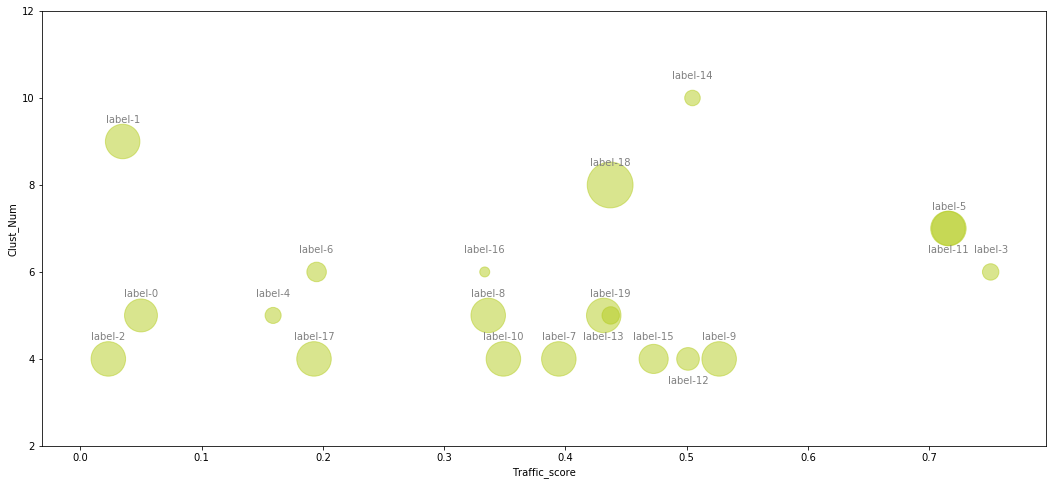

In [205]:
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(111)

color = (180/255,204/255,30/255)

results.plot(kind='scatter',
                  x = 'Traffic_score',
                  y = 'Clust_Num',
                  ylim = (2,12),
                  figsize = (18,8),
                  alpha = 0.5,
                  color = color,
                  s = Rent_avg_MM*2000 + 100,
                  ax = ax)

for index,row in results.iterrows():
    if index in [11,12,13]:
          ax.text(x=row['Traffic_score'], y=row['Clust_Num']-0.5, s='label-'+str(index), 
            ha='center', va= 'center',fontsize=10, color='gray')  
    else:
        ax.text(x=row['Traffic_score'], y=row['Clust_Num']+0.5, s='label-'+str(index), 
                ha='center', va= 'center',fontsize=10, color='gray')



气泡图已经绘制完成，按照我们的设置，我们应该尽量选择处于右上角且圆面积尽量小的集群。  
**从图上我们可以看出**：`label-3`,`label-5`,`label-11`,`label-14` 就是我们要的最终结果。

In [233]:
results = results.iloc[[3,5,11,14],:]
results

,address,latitude,longitude,X,Y,Cover radius,Bus_Nums,Subway_Nums,Park_Nums,Traffic_score,rent_avg,Clust_Num,Rent_avg_MM
label,,,,,,,,,,,,,
3,太和街道,25.029438,102.718111,269750.806568,2.770148e+06,264.575131,42,2,28,0.750626,2.455000,6,0.085110
5,吴井街道 朝阳路,25.039074,102.734776,271450.806568,2.771187e+06,400.000000,31,2,39,0.716190,5.598828,7,0.545118
11,华山街道,25.049103,102.704300,268393.663711,2.772350e+06,360.555128,59,1,53,0.715385,5.598828,7,0.545118
14,丰宁街道 滇缅大道,25.055858,102.687696,266730.806568,2.773127e+06,560.000000,47,1,20,0.504741,2.358333,10,0.070966


最后，将这些位置标记在地图上

In [219]:
#筛选出这几个集群的区域
results_clus = df_good_locations.loc[df_good_locations['Clus_Db'].isin([3,5,11,14])]

In [234]:
from folium.features import DivIcon

tites='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png'   #cartodbpositron
attr = '<a href="http://cartodb.com/attributions">CartoDB</a>'

colors = ['lightgreen', 'red', 'black', 'purple', 'lightblue', 'orange', 'pink', 'gray', 'lightgray','darkred',
          'darkgreen', 'darkblue', 'blue', 'red', 'green', 'lightred', 'beige', 'cadetblue', 'darkpurple','lightgreen', 'beige']

final_map = folium.Map(location=KM_wh, tiles=tites, attr=attr, zoom_start=14)

for index,row in results_clus.iterrows():
    c = colors[np.int(row['Clus_Db'])]
    folium.Circle([row['Latitude'], row['Longitude']], radius=50, color=c, 
                  fill=True, fill_color=c,fill_opacity=0.3).add_to(final_map)


for index,row in results.iterrows():
    icon=DivIcon(icon_size=(150,36),icon_anchor=(7,20),html='<div style="font-size: 18pt; color : black">{}</div>'.format(index))
    folium.Marker([row['latitude'], row['longitude']], icon=icon).add_to(final_map)
    

In [235]:
final_map

## 7. 结论<a name="结论"></a>

通过对客流量，同业竞争程度，交通便利程度，租金四个方面的探索，最终得出了四个最佳的火锅店选址范围，分别是：`label-3`,`label-5`,`label-11`,`label-14` 。分别对应：`太和街道`；`吴井街道朝阳路`；`华山街道`；`丰宁街道滇缅大道`。

到此，整个分析过程就全部结束了，虽然得到了最终的结果，但这个结果是否是最佳的，我个人认为还是存在一些再讨论空间的。比如：在第二部分，确定区域筛选条件时，餐馆数量为什么是7-12而不是7-15；地铁公交自驾的占比为什么是5：3：2而不是其他值？虽然这些数据、比值我在分析的过程中做过一些验证以保证其不要对结果造成比较大的影响，但终究这些都是我个人的主观判断，没有实际的数据或理论作为支撑。再比如：区域商铺租金的数据比较少，导致准确性不足，所以我最终只能将其作为参考值来使用。  
综上所述，该分析结论还存在一些漏洞，但基于时间原因，只能暂时到这。后续如果有时间我会继续完善。